<a href="https://colab.research.google.com/github/konkolyseismolab/seismolab/blob/master/docs/source/time_frequency_transformations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

[Open this tutorial in Google Colab](https://colab.research.google.com/github/konkolyseismolab/seismolab/blob/master/docs/source/time_frequency_transformations.ipynb)

# Time-frequency analysis

[Time-frequency representation](https://en.wikipedia.org/wiki/Time%E2%80%93frequency_analysis) of a non-stationary signal yields information about characteristics of the data set in the time-frequency plane. In contrast to the Fourier-transform, these techniques transform the signal into a two dimensional plane.

The detailed mathematical background of these methods can be found in [Kolláth & Buchler, 1997, NYASA, 808, 116](https://ui.adsabs.harvard.edu/abs/1997NYASA.808..116K/abstract) and [Choi & Williams, 1989, 37, 862](https://ieeexplore.ieee.org/document/28057).

## Short-time Fourier transform

The short-time Fourier transform (STFT), or windowed Fourier transform is the convolution of the spectra and the shifted window:

$$ STFT(t,\nu) = \int_{-\infty}^{\infty} f(\tau) w^*(\tau - t) \exp(-2i\pi\tau\nu ) d\tau ,$$

where $f(\tau)$ is the signal to be transformed and $w(t)$ is the window function.

The analyzing window $w(t)$ is selected to be a Gaussian

$$ w(t) = \exp\bigg( - \frac{t^{2}}{2 \sigma^{2}} \bigg) ,$$

where $\sigma$ is the width of the window.

This time-frequency distribution ss called the __Gábor transform__.

For computational efficiency, we implemented another solution as well, where the data is convolved by the Gaussion window and the Fourier transform is calculated from the Lomb-Scargle periodogram. This is called the __Windowed Lomb-Scargle transform__.

## Morlet wavelet transform

The wavelet transform has the form of

$$ S(t,a) = a^{-1/2} \int_{-\infty}^{\infty} f(\tau) g^*\bigg(\frac{\tau-t}{a}\bigg) dt, $$

where $f(\tau)$ is the signal to be transformed and $g(t)$ is the kernel of the wavelet transformation. The variable $a$ is the scale (period) parameter. The simplified Morlet wavelet kernel is:

$$ g(x) = exp\bigg( -\frac{x^2}{2} + icx \bigg) ,$$

where parameter $c$ controls the ratio of the time and frequency resolution. The time-scale version of the wavelet transform can be transformed to time-frequency representation:

$$ T(t,\nu) = a^{-1/2} S(t,a(\nu)), $$

where $\nu$ is the frequency and the scaling $ a(\nu) = c/(2\pi\nu) $.


## Choi-Williams transform

The generalized form of time-frequency distributions (GTFD) was introduced by [Cohen (1966)](https://aip.scitation.org/doi/10.1063/1.1931206). The Choi-Williams distribution (CWD) is one of a class of GTFD. In discrete form, the CWD can be expressed as ([see e.g. Hollinger's thesis](https://core.ac.uk/download/pdf/36698139.pdf))

$$ CWD(t,\nu) = 2 \sum_{\tau=-\infty}^{\infty} W(\tau) S(t,\nu) \exp(-2i\pi\tau\nu) ,$$

where

$$ S(t,\nu) = \sum_{\mu=-\infty}^{\infty} W(\mu) \frac{1}{\sqrt{4\pi \tau^2/\sigma}} exp\bigg( -\frac{(\mu-t)^2}{4\tau^2/\sigma} \bigg) f\bigg(\mu+\frac{\tau}{2}\bigg) f^*\bigg(\mu-\frac{\tau}{2}\bigg) ,$$

where $W(\mu)$ is a uniform window that has a value of one for the range $-N/2$ through $N/2$, and $W(\tau)$ is a uniform window that has a value of one for the range $-M/2$ through $M/2$ and is zero elsewhere.

The parameter $M$, the length of the window $W(\tau)$, determines the frequency resolution of the CWD. The parameter $N$, the length of the window $W(\mu)$, determines the range from which the time indexed autocorrelation function is to be estimated.

In practice, the length of the temporal window is given by $M$ times the sampling time. The $\sigma$ parameter roughly controls the time resolution. And $N$ is given by the maximum frequency, i.e., this is a fix parameter.

__Note:__ this method yields a power spectrum, thus if there are both large and small amplitude variations in the light curve, the latter will be supressed.

__Note:__ because the convolution is done with points sampled at $\pm\tau/2$ and the light curve is discretely sampled, the Nyquist limit is half of that expected!

## __How to use__

In [1]:
from seismolab.tfa import windowed_lomb_scargle
from seismolab.tfa import gabor, wavelet, choi_williams

from seismolab.fourier import Fourier
from seismolab.inpainting import kinpainting, insert_gaps

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

We generate an artifical periodic light curve with random gaps. The light curve consists of two sinusoidal signals with slightly different amplitudes. The latter's period is 0.3 days, while the former's 0.12 days, which is linearly increasing by time. To simulate more realistic data set, we randomly drop 5% of the points and a zero point to the observation times.

In [2]:
np.random.seed(12345)

# First time series with linearly increasing period
time1 = np.linspace(0,12,500)
mag1 = 0.1 * np.sin(2*np.pi*time1/(0.12 + 0.01*np.linspace(0,1,len(time1))) )

# Second time series with fix period
time2 = np.linspace(13,19,250)
mag2 = 0.08 * np.sin(2*np.pi*time2/0.3 + 0.1)

# Concatenate time series
time = np.r_[time1,time2]
mag = np.r_[mag1,mag2]

# Randomly choose values to simulate missing points
choosen_values = np.random.choice( np.arange(time.shape[0]), size=int(time.shape[0]*.95), replace=False) 
time = time[ choosen_values]
mag  = mag[  choosen_values]

# Sort values by time
keysort = np.argsort(time)
time = time[ keysort]
mag  = mag[  keysort]

# Add time and brightness nullpoint
time = time + 1400.
mag  = mag + 10.

# Randomly generated and add noise
mag += np.random.normal(0,0.005,time.shape[0])

The Fourier spectrum of the light curve shows two peaks corresponding to the injected periods. The linearly increasing period appears as a wide peak hiding the temporal evolution of the 0.12 days period. To resolve this issue, we need 2-D transformation techniques.

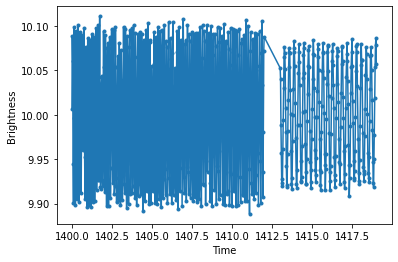

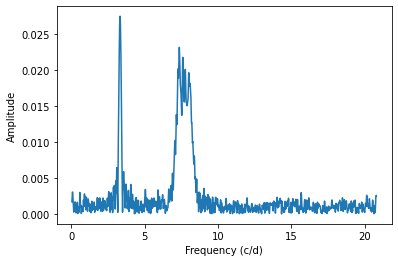

In [3]:
plt.plot(time,mag,'.',ls='-')
plt.xlabel('Time')
plt.ylabel('Brightness')
plt.show()

FFf, FFp = Fourier(time,mag).spectrum()

plt.plot(FFf,FFp)
plt.xlabel('Frequency (c/d)')
plt.ylabel('Amplitude')
plt.show()

### Evenly sampling

Because the time-frequency transformation methods require evenly sampled light curves, we use the inpainting technique from `seismolab.inpainting` to interpolate the time series in a regular grid.

In [4]:
inpainted, inpainted_irreg = kinpainting(time,mag)

ALLO ALLO Signal size: Nx = 791
ALLOC: Selection:Multiscale Local Discrete Cosinus Transform
   Band 1, BlockSize = 512, Nx = 2048 
   Band 2, BlockSize = 512, Nx = 2048 
   Band 3, BlockSize = 512, Nx = 2048 
   Band 4, BlockSize = 512, Nx = 2048 
   Band 5, BlockSize = 512, Nx = 2048 
   Band 6, BlockSize = 512, Nx = 2048 


The time and brightness points are separated for clarity.

In [5]:
time_new = inpainted[:,0]
mag_new  = inpainted[:,1]

As the inpolation is unreliable for larger gaps, we inserte gaps into the interpolated light curve that are longer than 0.1 days and present in the original times series.

In [6]:
time,mag = insert_gaps(time, time_new, mag_new, max_gap_size=0.1)

### Windowed Lomb-Scargle transform

The Windowed Lomb-Scargle transform can be performed by passing the `time` and `brightness` values to the `windowed_lomb_scargle` function. The available options are detailed below.

In [7]:
midtimes_wls, freqs_wls, powers_wls = windowed_lomb_scargle(
            time,                   # Time values of the light curve
            mag,                    # Brightness values of the light curve
    
            sigma=0.5,              # The width of the Gaussian analyzing window
    
            minimum_frequency=None, # For frequency grid calculation
            maximum_frequency=None, # Overwrites nyquist_factor!
            nyquist_factor=1,       # For frequency grid calculation
            samples_per_peak=10,    # Oversampling factor in frequency grid calculation
    
            Ntimes=100              # The number of time points to generate a uniformly sampled time grid
        )

The results are stored in three 2-D arrays:

- `midtimes_wls` contains the time grid,
- `freqs_wls` contains the frequency grid,
- `powers_wls` contains the calculated amplitudes.

The results can be visualized e.g., as follows, by plotting the calculated map along with the time series (top) and the Fourier spectrum (left).

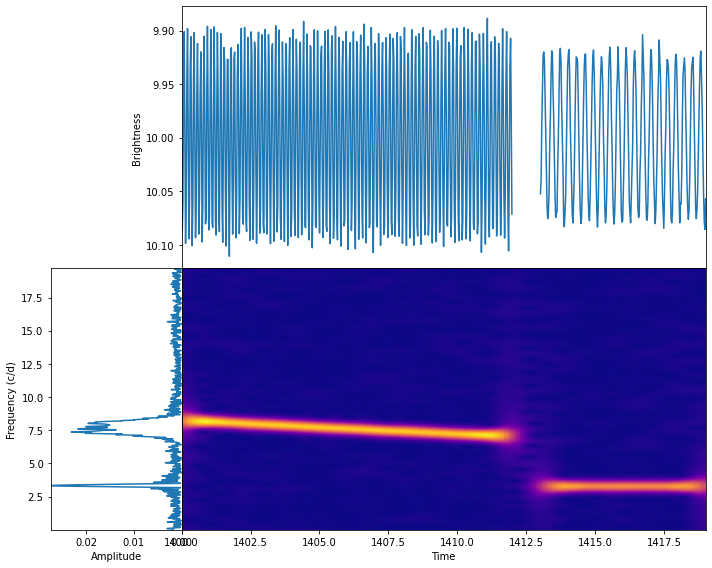

In [8]:
fig = plt.figure(figsize=(10,8))
gs = GridSpec(2,2,figure=fig,width_ratios=[0.2,0.8],wspace=0,hspace=0)
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[1,1])
ax3 = plt.subplot(gs[1,0])

gaps = np.where(np.diff(time) > 0.5)[0] + 1
ax1.plot( np.insert(time,gaps,np.nan), np.insert(mag,gaps,np.nan))
cb = ax2.pcolormesh(midtimes_wls,freqs_wls,powers_wls.T,cmap='plasma',shading='gouraud')
#plt.colorbar(cb)
ax3.plot(FFp,FFf)
ax3.set_ylim(freqs_wls.min(),freqs_wls.max())
ax2.set_ylim(freqs_wls.min(),freqs_wls.max())
ax2.set_yticks([])
ax1.set_xticks([])
ax1.set_xlim(time.min(),time.max())
ax2.set_xlim(time.min(),time.max())
ax3.set_xlim(FFp.max(),0)
ax1.invert_yaxis()
ax1.set_ylabel('Brightness')
ax2.set_xlabel('Time')
ax3.set_xlabel('Amplitude')
ax3.set_ylabel('Frequency (c/d)')
plt.tight_layout()
plt.show()

### Gábor transform

The Gábor transform can be performed by passing the `time` and `brightness` values to the `gabor` function. The available options are detailed below.

In [9]:
midtimes_gbr, freqs_gbr, powers_gbr = gabor(
            time,                   # Time values of the light curve
            mag,                    # Brightness values of the light curve

            sigma=0.5,              # The width of the Gaussian analyzing window

            minimum_frequency=None, # For frequency grid calculation
            maximum_frequency=None, # Overwrites nyquist_factor!
            nyquist_factor=1,       # For frequency grid calculation
            samples_per_peak=10,    # Oversampling factor in frequency grid calculation

            Ntimes=100,             # The number of time points to generate a uniformly sampled time grid

            ncores=-1               # Number of CPU cores to be used for parallel calculation (`-1` = all)
        )

0it [00:00, ?it/s]

The results are stored in three 2-D arrays:

- `midtimes_gbr` contains the time grid,
- `freqs_gbr` contains the frequency grid,
- `powers_gbr` contains the calculated amplitudes.

The results can be visualized e.g., as follows, by plotting the calculated map along with the time series (top) and the Fourier spectrum (left).

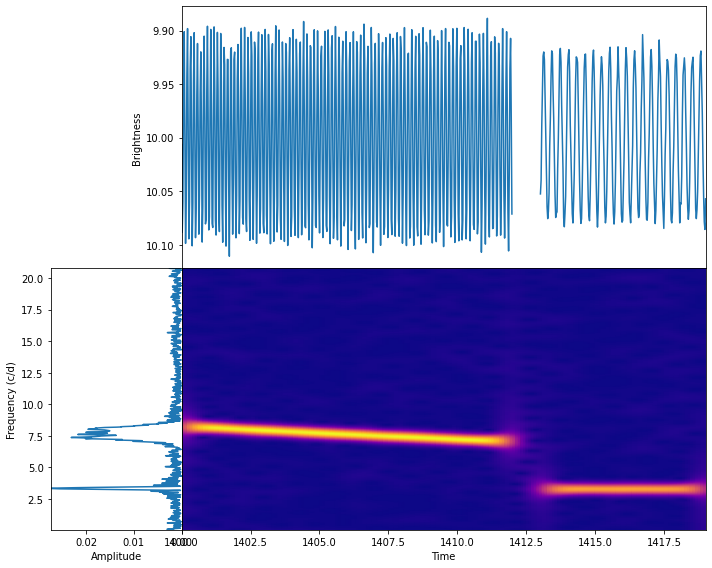

In [10]:
fig = plt.figure(figsize=(10,8))
gs = GridSpec(2,2,figure=fig,width_ratios=[0.2,0.8],wspace=0,hspace=0)
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[1,1])
ax3 = plt.subplot(gs[1,0])

gaps = np.where(np.diff(time) > 0.5)[0] + 1
ax1.plot( np.insert(time,gaps,np.nan), np.insert(mag,gaps,np.nan))
cb = ax2.pcolormesh(midtimes_gbr,freqs_gbr,powers_gbr.T,cmap='plasma',shading='gouraud')
#plt.colorbar(cb)
ax3.plot(FFp,FFf)
ax3.set_ylim(freqs_gbr.min(),freqs_gbr.max())
ax2.set_ylim(freqs_gbr.min(),freqs_gbr.max())
ax2.set_yticks([])
ax1.set_xticks([])
ax1.set_xlim(time.min(),time.max())
ax2.set_xlim(time.min(),time.max())
ax3.set_xlim(FFp.max(),0)
ax1.invert_yaxis()
ax1.set_ylabel('Brightness')
ax2.set_xlabel('Time')
ax3.set_xlabel('Amplitude')
ax3.set_ylabel('Frequency (c/d)')
plt.tight_layout()
plt.show()

### Morlet Wavelet transform

The Morlet Wavelet transform can be performed by passing the `time` and `brightness` values to the `wavelet` function. The available options are detailed below.

In [11]:
midtimes_w, freqs_w, powers_w = wavelet(
            time,                   # Time values of the light curve
            mag,                    # Brightness values of the light curve
    
            c=6.283185307179586,    # The scale parameter. (Usually, it is 2*Pi)
    
            minimum_frequency=None, # For frequency grid calculation
            maximum_frequency=None, # Overwrites nyquist_factor!
            nyquist_factor=1,       # For frequency grid calculation
            samples_per_peak=10,    # Oversampling factor in frequency grid calculation

            Ntimes=100,             # The number of time points to generate a uniformly sampled time grid

            ncores=-1               # Number of CPU cores to be used for parallel calculation (`-1` = all)
        )

0it [00:00, ?it/s]

The results are stored in three 2-D arrays:

- `midtimes_w` contains the time grid,
- `freqs_w` contains the frequency grid,
- `powers_w` contains the calculated amplitudes.

The results can be visualized e.g., as follows, by plotting the calculated map along with the time series (top) and the Fourier spectrum (left).

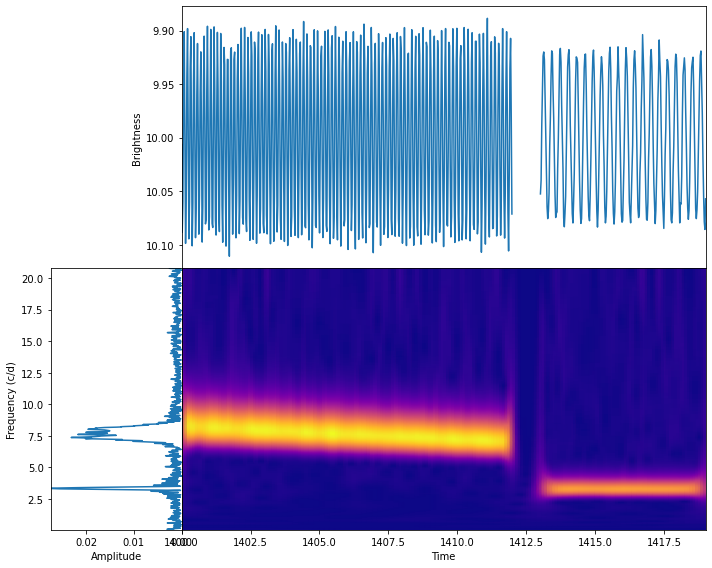

In [12]:
fig = plt.figure(figsize=(10,8))
gs = GridSpec(2,2,figure=fig,width_ratios=[0.2,0.8],wspace=0,hspace=0)
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[1,1])
ax3 = plt.subplot(gs[1,0])

gaps = np.where(np.diff(time) > 0.5)[0] + 1
ax1.plot( np.insert(time,gaps,np.nan), np.insert(mag,gaps,np.nan))
cb = ax2.pcolormesh(midtimes_w,freqs_w,powers_w.T,cmap='plasma',shading='gouraud')
#plt.colorbar(cb)
ax3.plot(FFp,FFf)
ax3.set_ylim(freqs_w.min(),freqs_w.max())
ax2.set_ylim(freqs_w.min(),freqs_w.max())
ax2.set_yticks([])
ax1.set_xticks([])
ax1.set_xlim(time.min(),time.max())
ax2.set_xlim(time.min(),time.max())
ax3.set_xlim(FFp.max(),0)
ax1.invert_yaxis()
ax1.set_ylabel('Brightness')
ax2.set_xlabel('Time')
ax3.set_xlabel('Amplitude')
ax3.set_ylabel('Frequency (c/d)')
plt.tight_layout()
plt.show()

### Choi and Williams transform

The Choi and Williams transform can be performed by passing the `time` and `brightness` values to the `choi_williams` function. The available options are detailed below.

In [13]:
midtimes_choi, freqs_choi, powers_choi = choi_williams(
            time,                   # Time values of the light curve
            mag,                    # Brightness values of the light curve
    
            sigma=4.,               # The width of the kernel of the analyzing window
            M=128,                  # This controls the length of the temporal window, which is given by M times the sampling time
    
            minimum_frequency=None, # For frequency grid calculation
            maximum_frequency=None, # Overwrites nyquist_factor!
            nyquist_factor=1,       # For frequency grid calculation
            samples_per_peak=1,     # Oversampling factor in frequency grid calculation
    
            Ntimes=100,             # The number of time points to generate a uniformly sampled time grid
    
            max_gap_size=0.5,       # Maximal size of gaps which is used to split the time series into chunks
    
            ncores=-1               # Number of CPU cores to be used for parallel calculation (`-1` = all)
        )

0it [00:00, ?it/s]

The results are stored in three 2-D arrays:

- `midtimes_choi` contains the time grid,
- `freqs_choi` contains the frequency grid,
- `powers_choi` contains the calculated amplitudes.

The results can be visualized e.g., as follows, by plotting the calculated map along with the time series (top) and the Fourier spectrum (left).

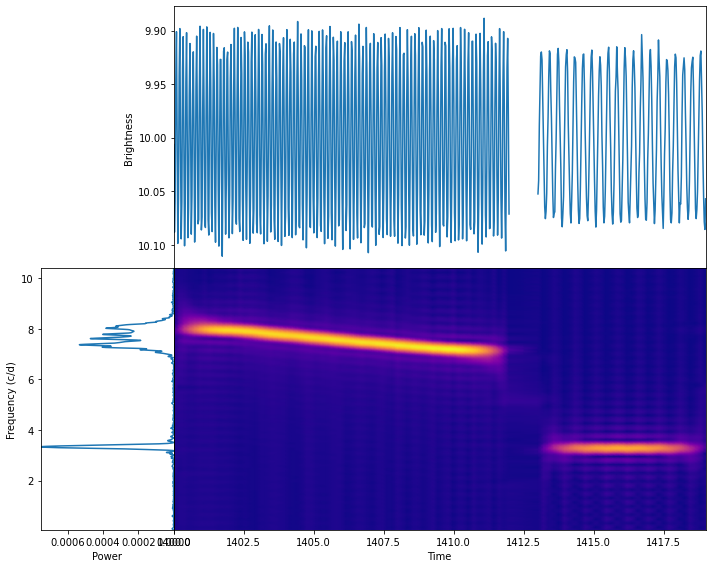

In [14]:
fig = plt.figure(figsize=(10,8))
gs = GridSpec(2,2,figure=fig,width_ratios=[0.2,0.8],wspace=0,hspace=0)
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[1,1])
ax3 = plt.subplot(gs[1,0])

gaps = np.where(np.diff(time) > 0.5)[0] + 1
ax1.plot( np.insert(time,gaps,np.nan), np.insert(mag,gaps,np.nan))
cb = ax2.pcolormesh(midtimes_choi,freqs_choi,powers_choi.T,cmap='plasma',shading='gouraud')
#plt.colorbar(cb)
ax3.plot(FFp**2,FFf)
ax3.set_ylim(freqs_choi.min(),freqs_choi.max())
ax2.set_ylim(freqs_choi.min(),freqs_choi.max())
ax2.set_yticks([])
ax1.set_xticks([])
ax1.set_xlim(time.min(),time.max())
ax2.set_xlim(time.min(),time.max())
ax3.set_xlim((FFp**2).max(),0)
ax1.invert_yaxis()
ax1.set_ylabel('Brightness')
ax2.set_xlabel('Time')
ax3.set_xlabel('Power')
ax3.set_ylabel('Frequency (c/d)')
plt.tight_layout()
plt.show()

### Comparing the time-frequency transformation methods

To visually compare the performance of the time-frequency transformation methods, we can collect the previous results in one figure.

It can be clearly seen that the Windowed Lomb-Scargle gives almost the same as the Gábor transform. However, the former takes much less time.

The resolution of the wavelet strongly depends on the frequency. This time-frequency resolution degeneracy can be controlled by the _c_ parameter.

The Choi-Williams transformation gives the highest resolution both in time and frequency at the cost of stronger alias peaks and lower Nyquist limit.

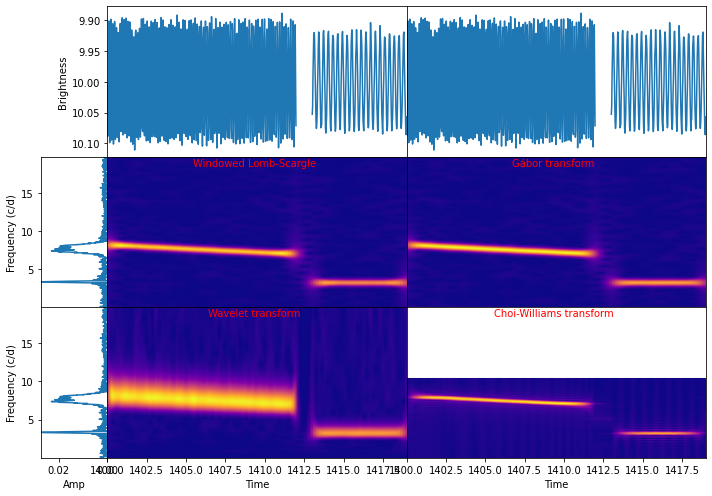

In [15]:
fig = plt.figure(figsize=(10,7))
gs = GridSpec(3,3,figure=fig,width_ratios=[0.1,0.45,0.45],wspace=0,hspace=0)
axts1 = plt.subplot(gs[0,1])
axts2 = plt.subplot(gs[0,2])
axspec1 = plt.subplot(gs[1,0])
axspec2 = plt.subplot(gs[2,0])
axmap1 = plt.subplot(gs[1,1])
axmap2 = plt.subplot(gs[1,2])
axmap3 = plt.subplot(gs[2,1])
axmap4 = plt.subplot(gs[2,2])

gaps = np.where(np.diff(time) > 0.5)[0] + 1
axts1.plot( np.insert(time,gaps,np.nan), np.insert(mag,gaps,np.nan))
axts2.plot( np.insert(time,gaps,np.nan), np.insert(mag,gaps,np.nan))
axts1.set_xticks([])
axts2.set_xticks([])
axts2.set_yticks([])
axts1.set_xlim(time.min(),time.max())
axts2.set_xlim(time.min(),time.max())
axts1.invert_yaxis()
axts2.invert_yaxis()

axspec1.plot(FFp,FFf)
axspec2.plot(FFp,FFf)
axspec1.set_ylim(freqs_wls.min(),freqs_wls.max())
axspec2.set_ylim(freqs_wls.min(),freqs_wls.max())
axspec1.set_xlim((FFp).max(),0)
axspec2.set_xlim((FFp).max(),0)

axmap1.pcolormesh(midtimes_wls,freqs_wls,powers_wls.T,cmap='plasma',shading='gouraud')
axmap2.pcolormesh(midtimes_gbr,freqs_gbr,powers_gbr.T,cmap='plasma',shading='gouraud')
axmap3.pcolormesh(midtimes_w,freqs_w,powers_w.T,cmap='plasma',shading='gouraud')
axmap4.pcolormesh(midtimes_choi,freqs_choi,powers_choi.T,cmap='plasma',shading='gouraud')

axmap1.set_ylim(freqs_wls.min(),freqs_wls.max())
axmap2.set_ylim(freqs_wls.min(),freqs_wls.max())
axmap3.set_ylim(freqs_wls.min(),freqs_wls.max())
axmap4.set_ylim(freqs_wls.min(),freqs_wls.max())
axmap1.set_xticks([])
axmap2.set_xticks([])
axmap1.set_yticks([])
axmap2.set_yticks([])
axmap3.set_yticks([])
axmap4.set_yticks([])
axmap1.set_xlim(time.min(),time.max())
axmap2.set_xlim(time.min(),time.max())
axmap3.set_xlim(time.min(),time.max())
axmap4.set_xlim(time.min(),time.max())

axts1.set_ylabel('Brightness')
axspec1.set_ylabel('Frequency (c/d)')
axspec2.set_ylabel('Frequency (c/d)')
axmap3.set_xlabel('Time')
axmap4.set_xlabel('Time')
axspec2.set_xlabel('Amp')

axmap1.text(np.mean(time),freqs_wls.max()-0.06*freqs_wls.ptp(),'Windowed Lomb-Scargle',fontdict={'color':'r','horizontalalignment':'center'})
axmap2.text(np.mean(time),freqs_wls.max()-0.06*freqs_wls.ptp(),'Gábor transform',fontdict={'color':'r','horizontalalignment':'center'})
axmap3.text(np.mean(time),freqs_wls.max()-0.06*freqs_wls.ptp(),'Wavelet transform',fontdict={'color':'r','horizontalalignment':'center'})
axmap4.text(np.mean(time),freqs_wls.max()-0.06*freqs_wls.ptp(),'Choi-Williams transform',fontdict={'color':'r','horizontalalignment':'center'})

plt.tight_layout()
plt.show()